# Directed hierarchical random graph
In this example, we will see how the algorithm works in a directed hierarchical random graph created by using the model from [Sales-Pardo M. et al. 2007](https://doi.org/10.1073/pnas.070374010)

First, let's import the libraries that we are going to use.

In [1]:
T = True
F = False
# Stadard python libs ----
import numpy as np
import seaborn as sns
sns.set_theme()
# Personal libs ----
from networks.toy import TOY
from modules.hierarmerge import Hierarchy
from modules.hierarentropy import Hierarchical_Entropy
from modules.colregion import colregion
from plotting_jupyter.plotting_H import Plot_H
from various.network_tools import get_best_kr, get_labels_from_Z, get_best_kr_equivalence

Create the HGR class that will create a homogeneous-directed hierarchical random graph with three levels. Depending on the level, two nodes belonging to the same community connect with probability $p=\frac{2}{360}$ for $l=0$, $p=\frac{2}{159}$ for $l=1$, $p=\frac{4}{39}$ for $l=2$, and $p=\frac{8}{9}$ for $l=3$.

In [2]:
class HRG:
  def __init__(self, N : int, group_sizes=[160, 40, 10], rho=1, kav=16, seed=-1) -> None:
    self.nodes = N
    self.rho = rho
    self.kav = kav
    self.group_sizes = np.array(group_sizes)
    self.lmax = len(group_sizes)
    self.A = np.zeros((N, N))
    self.labels = np.arange(N, dtype=int).astype(str)
    self.generate_membership_list()
    self.fill_adjacency_matrix(seed=seed)

  def get_p(self):
    p = np.zeros(len(self.group_sizes) + 1)
    p[0] = np.power(self.rho, self.lmax) / np.power(1 + self.rho, self.lmax) * (self.kav / (self.group_sizes[0] * self.lmax))
    for x, Sx in enumerate(self.group_sizes):
      x += 1
      p[x] = np.power(self.rho, self.lmax - x) / np.power(1 + self.rho, self.lmax - x + 1) * (self.kav / (Sx - 1))
    return p

  def fill_adjacency_matrix(self, seed=-1):
    if seed > 0:
      np.random.seed(seed)
    p = self.get_p()
    for i in np.arange(self.nodes):
      for j in np.arange(self.nodes):
        if i == j: continue
        members_i = self.node_memberships[i, :]
        members_j = self.node_memberships[j, :]
        compare = members_i == members_j
        kk = 0
        for k in np.arange(self.node_memberships.shape[1]):
          if compare[k]: kk += 1
          else: break
        if np.random.rand() < p[kk]: self.A[i, j] = 1      

  def generate_membership_list(self):
    memberships_options = np.arange(self.lmax + 1)
    self.node_memberships = np.zeros((self.nodes, len(self.group_sizes)))
    for i, size in enumerate(self.group_sizes):
      mem = np.repeat(memberships_options, size)
      if len(mem) < self.nodes:
        mem = np.tile(mem, int(self.nodes / len(mem)))
      self.node_memberships[:, i] = mem

Let's start defining some parameters for the algorithm and assigning them to a dictionary.

In [3]:
linkage = "single"
nlog10 = F
lookup = F
prob = F
cut = T                                       # We are reducing the number of steps in the
                                              # quality function maximization step by only
                                              # considering the steps where the distance
                                              # between merged link communities changed between
                                              # consecutive steps
mode = "ZERO"
topology = "MIX"
mapping="trivial"
index = "D1_2_3"
opt_score = ["_maxmu", "_X", "_D"]

properties = {
  "version" : "HRG",
  "nlog10" : nlog10,
  "lookup" : lookup,
  "prob" : prob,
  "cut" : cut,
  "topology" : topology,
  "mapping" : mapping,
  "index" : index,
  "mode" : mode,
}

We are going to create a network with 64O (N) nodes and let's run the code!

In [4]:
# Define parameters HRG
N = 640
hrg = HRG(N, seed=12345)
perm = np.random.permutation(np.arange(N))
hrg.A = hrg.A[perm, :][:, perm]                           # Permutation of the network before analysis
labels_dict = {i: hrg.labels[i] for i in np.arange(N)}
# Create TOY ---
NET = TOY(hrg.A, linkage, **properties)
NET.set_alpha([15, 50, 100])
NET.set_labels(hrg.labels)
H = Hierarchy(
  NET, hrg.A, hrg.A, np.zeros(hrg.A.shape),
  N, linkage, mode
)
## Compute quality functions ----
H.BH_features_parallel()
## Compute link entropy ----
H.link_entropy_cpp("short", cut=cut)
## Compute la arbre de merde ----
H.la_abre_a_merde_cpp(H.BH[0])
## Compute node entropy ----
H.node_entropy_cpp("short", cut=cut)
# Set labels to network ----
L = colregion(NET, labels=NET.labels)
L.get_regions()
H.set_colregion(L)
# Entropy ----
HS = Hierarchical_Entropy(H.Z, H.nodes, list(range(H.nodes)))
HS.Z2dict("short")
node_entropy = HS.S(HS.tree)
H.entropy = [
  H.node_entropy, H.node_entropy_H,
  H.link_entropy, H.link_entropy_H
]

Computing features over mu-score space


/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Starting Z2dict

	link entropy :  Sh : 0.3212, and Sv : 0.6788


	link entropy H: Sh : 0.3496, and Sv : 0.6504

Level information
Vertex entropy
Vertex entropy H
Level entropy
Level entropy H
Number of vertices in the tree: 18685
Commencer: la abre a merde
Voila, bon ami
Starting Z2dict
Level information
Vertex entropy
Vertex entropy H
Level entropy
Level entropy H
Number of vertices in the tree: 1279

	Node entropy :  Sh : 0.5588, and Sv : 0.4412


	Node entropy H: Sh : 0.5442, and Sv : 0.4558


	Node entropy :  Sh : 0.5588, and Sv : 0.4412



Let's see how the quality functions look like before looking at the node community partitions.

Visualize Entropy iterations!!!
Levels node hierarchy: 20
Levels link hierarchy: 1646
             S dir                 c  level
50    0.077736   H  node_hierarchy_H     10
73    0.054158   V  node_hierarchy_H      7
8     0.075972   H    node_hierarchy     12
27    0.042864   V    node_hierarchy     13
3404  0.006894   H  link_hierarchy_H   1614
5054  0.008096   V  link_hierarchy_H   1610
108   0.005858   H    link_hierarchy   1618
1753  0.006237   V    link_hierarchy   1619
Plot Mu iterations
Plot X iterations
Plot D iterations
Plot order parameter iterations


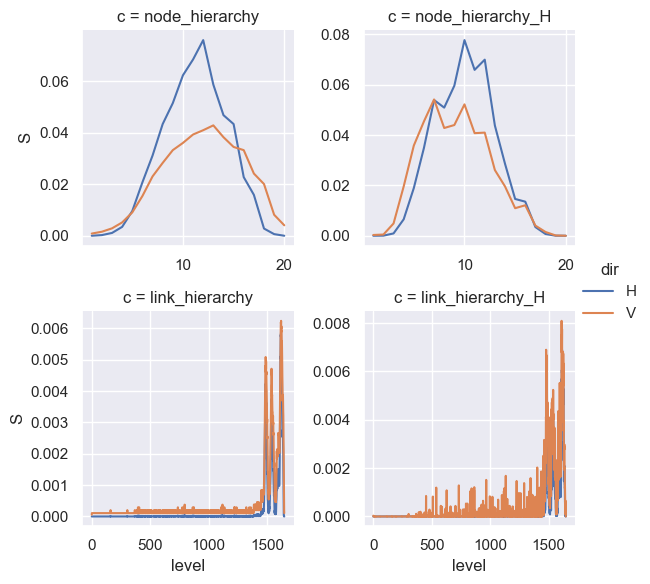

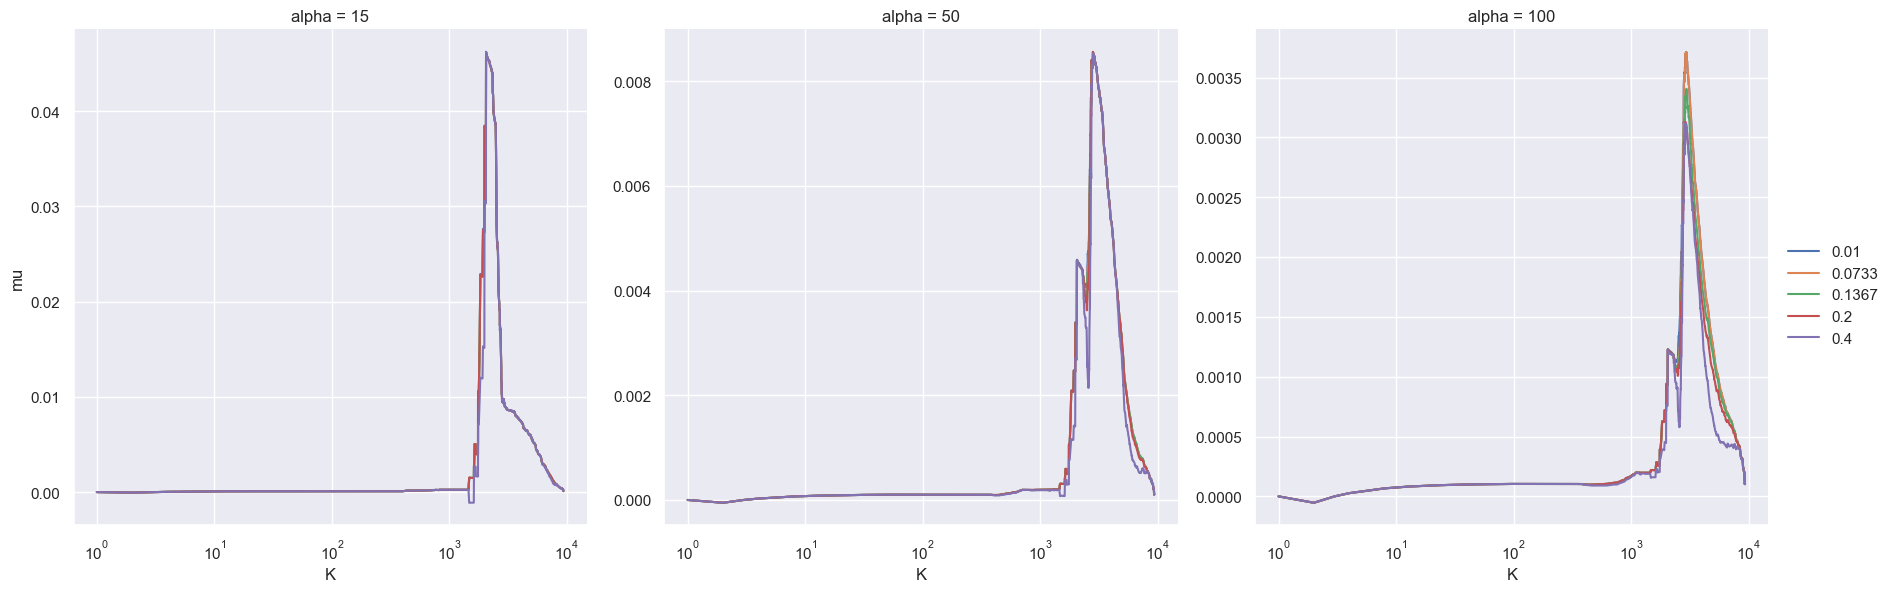

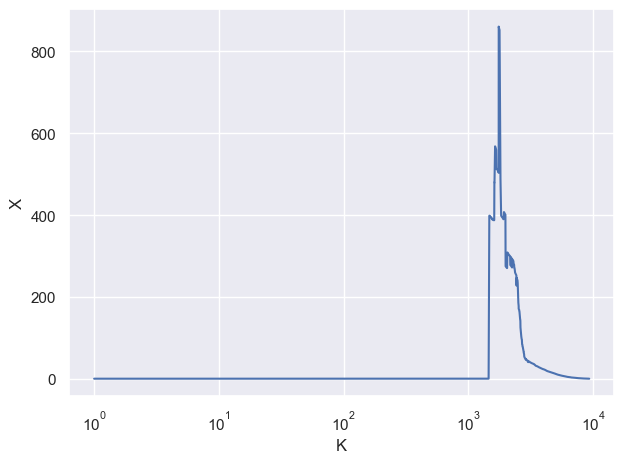

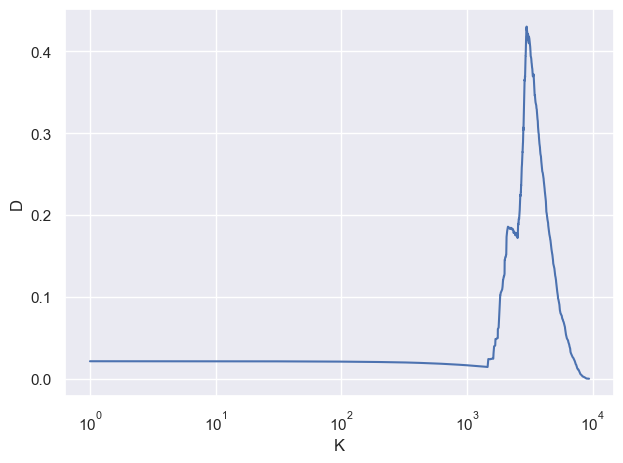

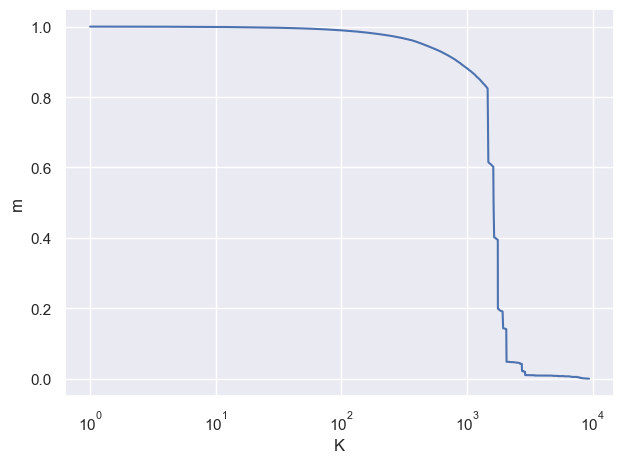

In [5]:
plot_h = Plot_H(NET, H)
plot_h.plot_measurements_Entropy()
plot_h.plot_measurements_mu()
plot_h.plot_measurements_X()
plot_h.plot_measurements_D()
plot_h.plot_measurements_order_parameter()

Notice the big jump in the order parameter. In the case of the existence of balanced similarity forces spanning the network, link communities will tend to form sparsely across the network. They will start agglomerating links and create robust structures. After a certain point, these structures collapse because of the vacuum force, making the giant component grow without control and overtaking the network. There are many parallels in the link between hierarchical agglomeration and percolation. In addition, by looking at the $\mu$-, $\chi$-score plots, we can observe how they tend to peak closer to the emerging of the giant component than $D$.

Now, look at the partition of the $\mu$-score:

Visualize k LCs!!!
Visualize node-community dendrogram!!!


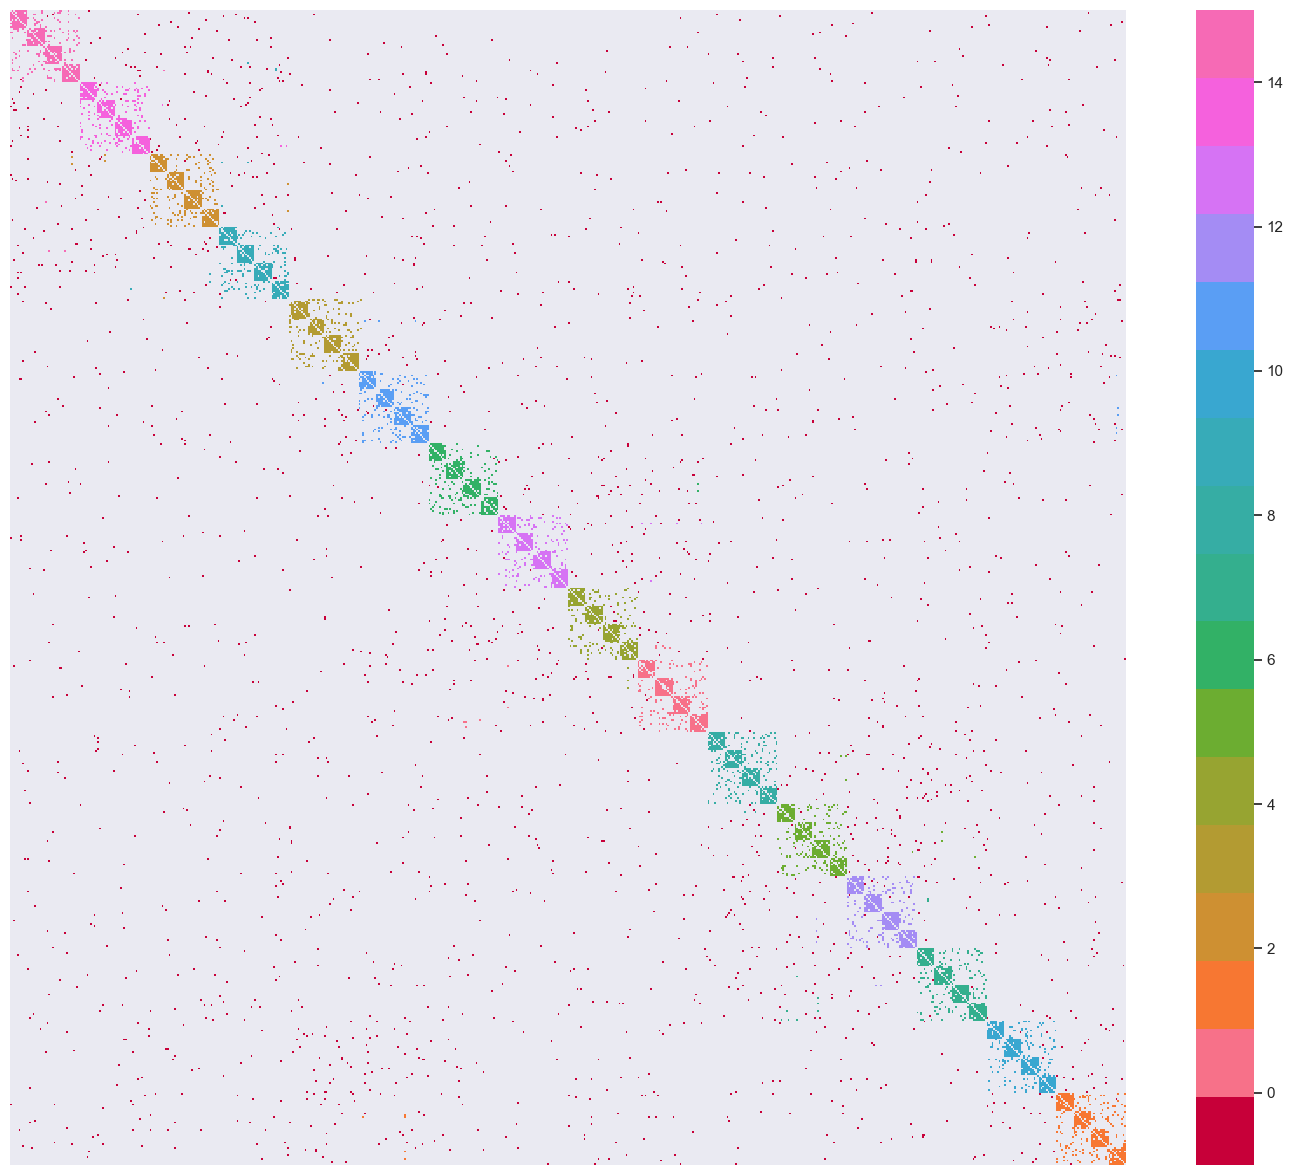

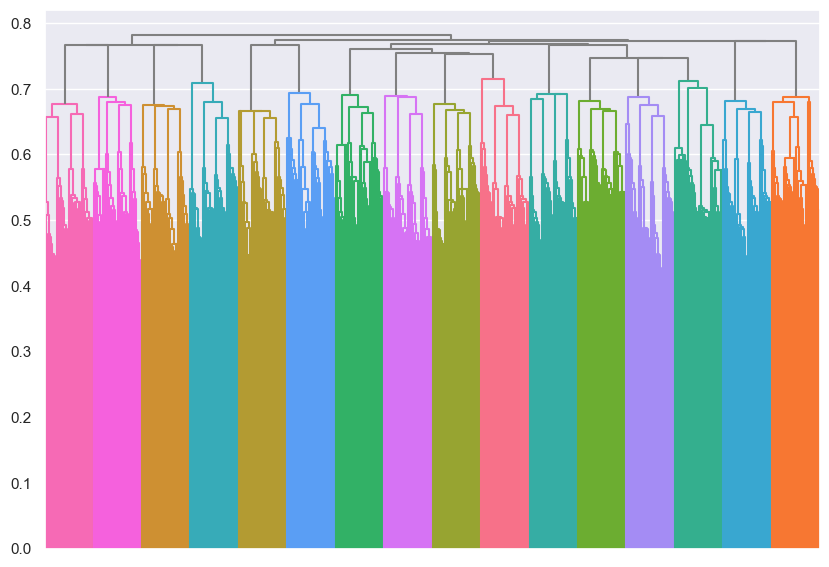

In [6]:
score = "_maxmu"
K, R = get_best_kr_equivalence(score, H)
r = R[K == np.min(K)][0]
k = K[K == np.min(K)][0]
rlabels = get_labels_from_Z(H.Z, r)
plot_h.lcmap_dendro(
  [k], cmap_name="husl", remove_labels=True
)
plot_h.core_dendrogram(
  [r], cmap_name="husl", remove_labels=True
)

The $\chi$ quality function

Visualize k LCs!!!
Visualize node-community dendrogram!!!


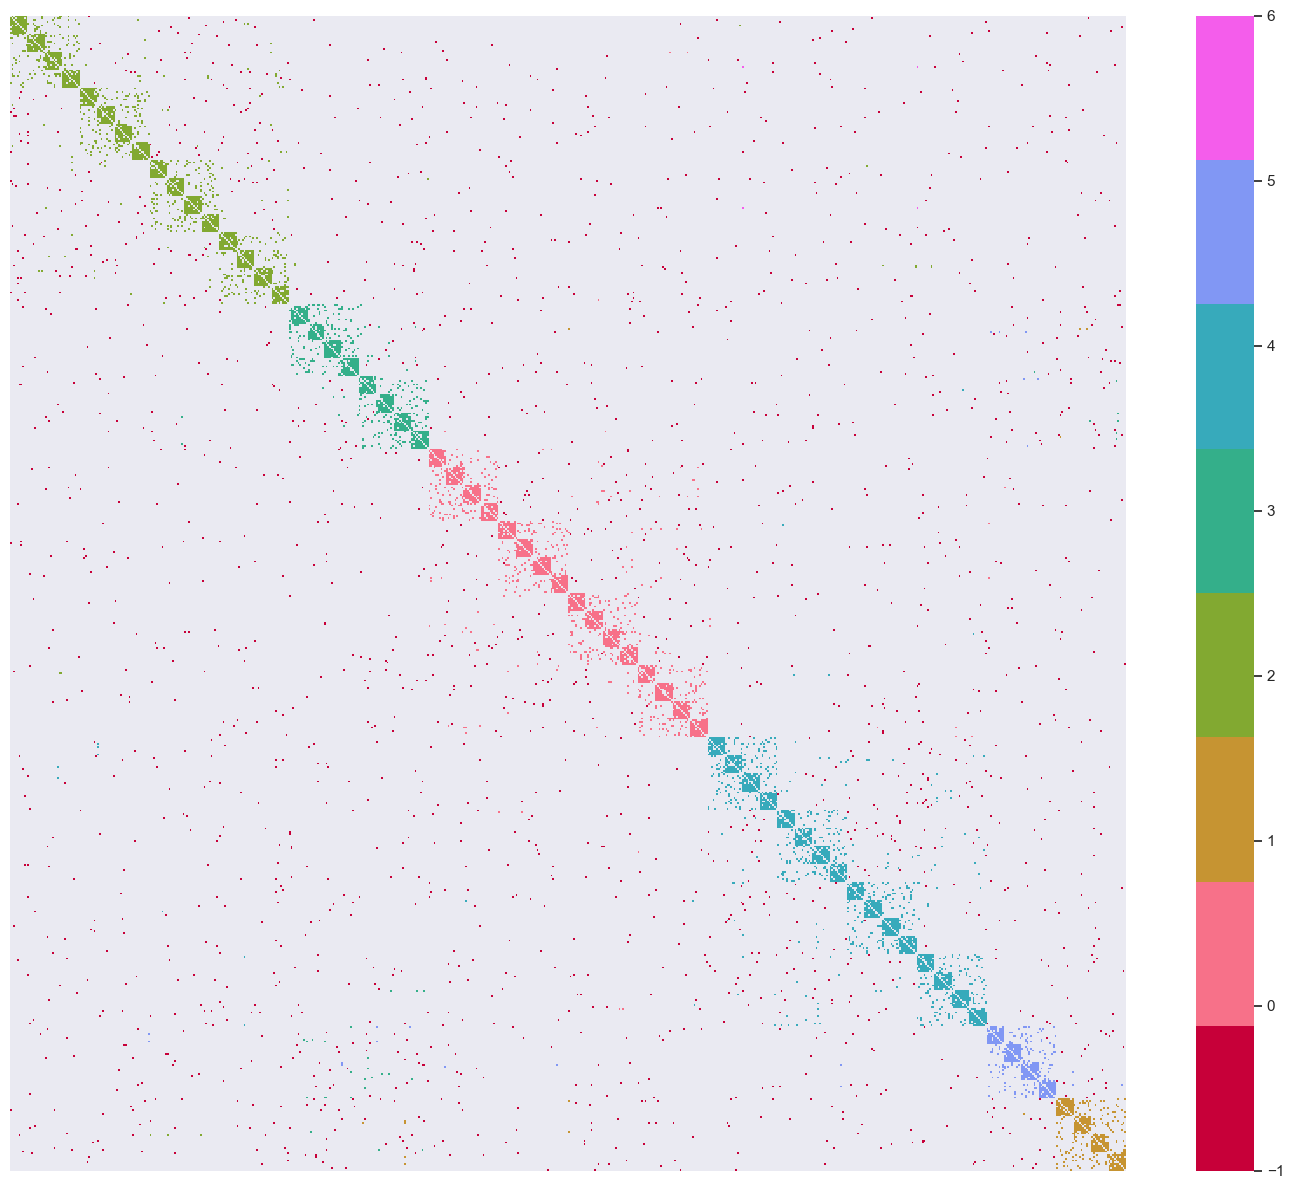

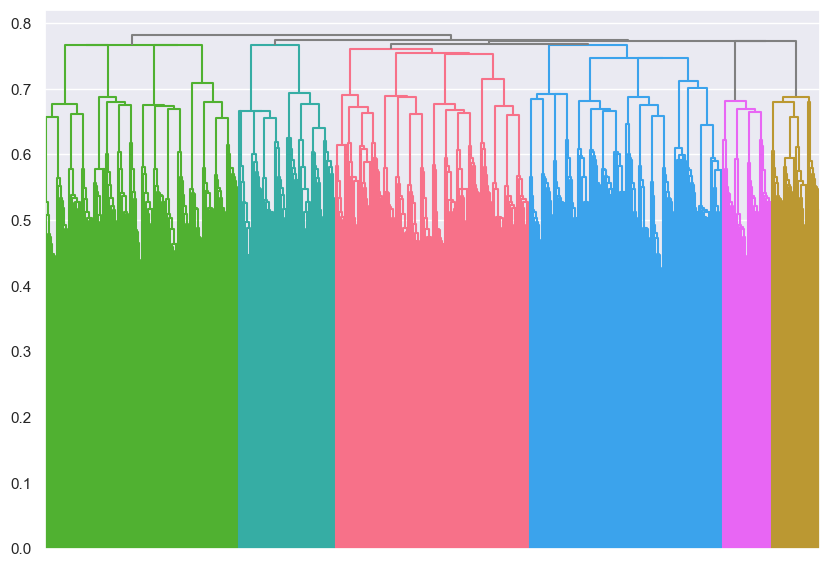

In [7]:
score = "_X"
K, R = get_best_kr_equivalence(score, H)
r = R[K == np.min(K)][0]
k = K[K == np.min(K)][0]
rlabels = get_labels_from_Z(H.Z, r)
plot_h.lcmap_dendro(
  [k], cmap_name="husl", remove_labels=True
)
plot_h.core_dendrogram(
  [r], cmap_name="husl", remove_labels=True
)

And the average link community density, $D$.

Visualize k LCs!!!
Visualize node-community dendrogram!!!


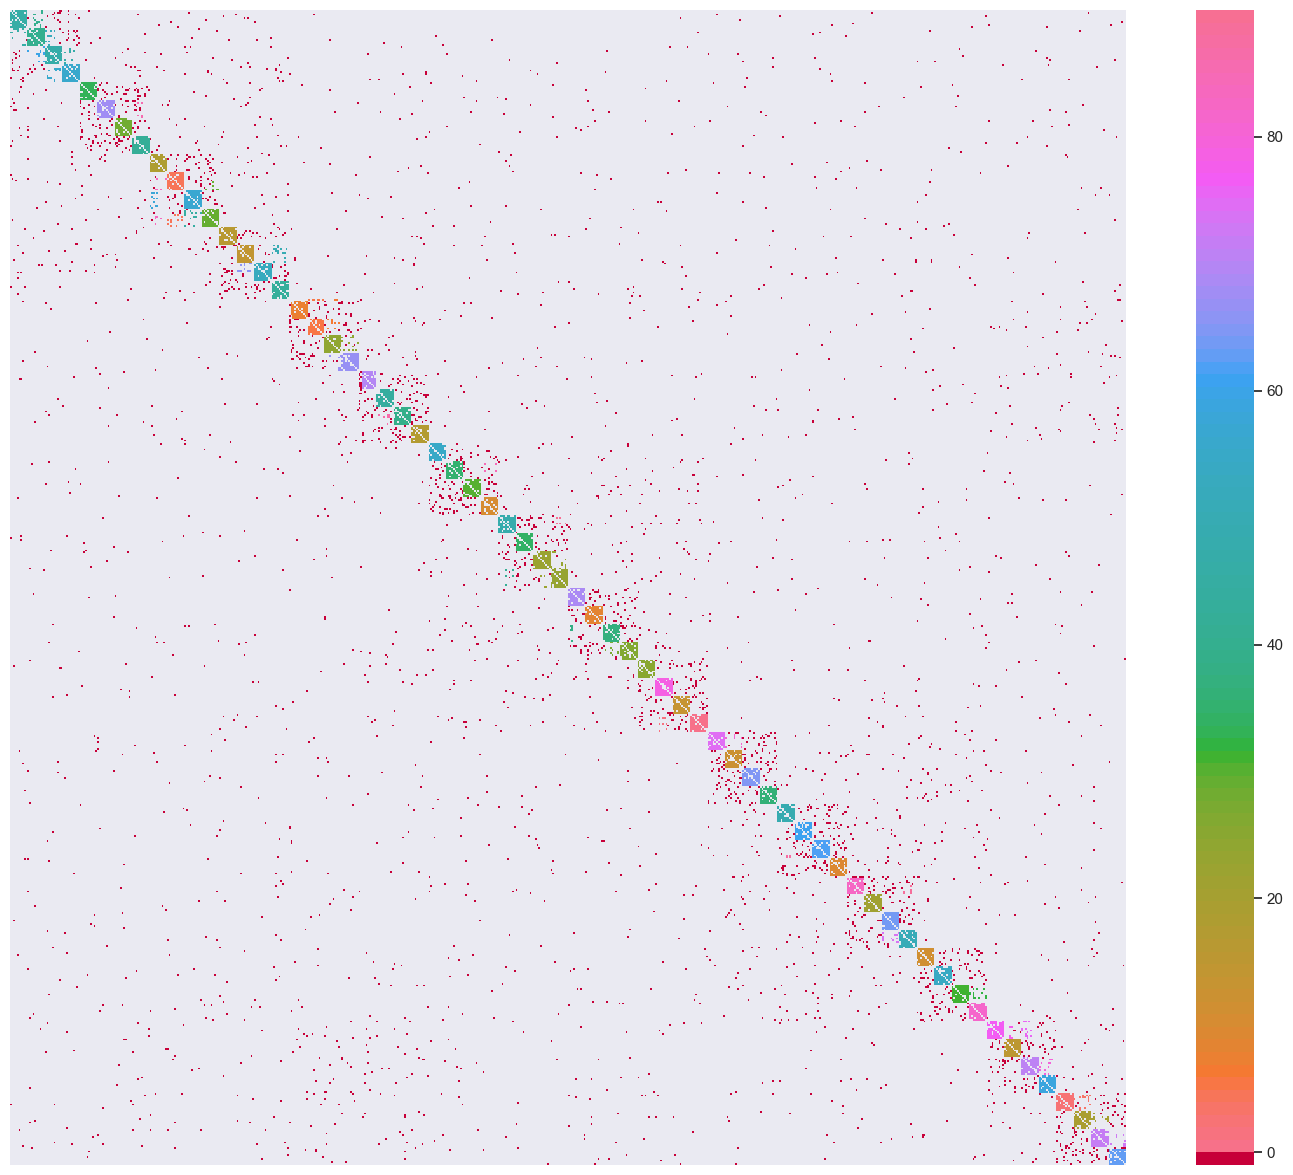

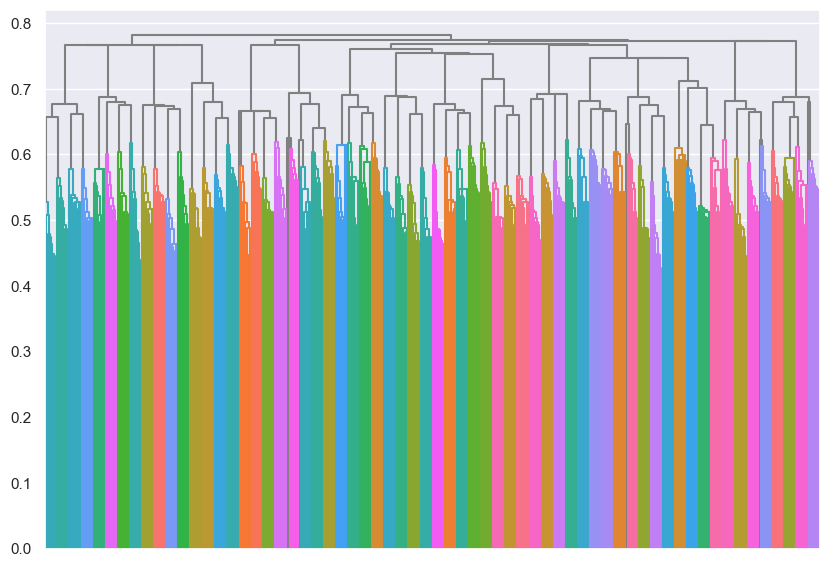

In [8]:
score = "_D"
K, R = get_best_kr_equivalence(score, H)
r = R[K == np.min(K)][0]
k = K[K == np.min(K)][0]
rlabels = get_labels_from_Z(H.Z, r)
plot_h.lcmap_dendro(
  [k], cmap_name="husl", remove_labels=True
)
plot_h.core_dendrogram(
  [r], cmap_name="husl", remove_labels=True
)

## Conclusions

In this example, we could see that Dlink works well in the case of hierarchical networks. The performance of the quality functions teaches us several things.

- The higher $\alpha$ values in the maximum $\mu$-score have lower strength with the maximum moving towards warmer (higher Ks) partitions. In this case, the heuristics discover the 16 node communities of the second level of the hierarchy.

- The $\chi$ score returns a partition with a colder K (number of link communities).

- The average link community density, $D$, found the warmest partition from the first hierarchy level with 64 node communities. We understand that this partition comes naturally since the network is sparse which makes the density of the subclusters the feature to organize the data with the lowest entropy.

Besides the performance of the quality functions, the real structure that encodes the most of information of the organization in this network is the node community dendrogram.